### 1.1 Importing modules

In [1]:
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import cv2

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf


In [3]:
# Model(input=[inputimage, verifyimage] ,outputs=[1,0])

### 1.2 Set GPU Memory Usage

In [3]:
#gradually increas GPU memory as needed for each gpus that are listed

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 1.3 Create Folder

In [5]:
# creating a variable of path    eg. data ---> positive

POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [7]:
# make directories

os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

##  2. Collect Positive and Anchors

### 2.1 Uncompress Tar Gz Dataset

In [ ]:
# http://vis-www.cs.umass.edu/lfw/

In [8]:
!tar -xf lfw.tgz

### 2.2 collect neg classes

In [9]:
# link : https://vis-www.cs.umass.edu/lfw/#download
#collect negative images from above link


for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw',directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

### 2.3 collect pos & anc classes

In [6]:
# import uuid to generate unique image names 

import uuid
uuid.uuid1()

UUID('b5b8accf-be11-11ee-b200-c85ea939b75e')

In [7]:
# establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    
    #cut down frame to 250,250,3 pixels
    frame = frame[120:120+250,200:200+250,:]

    



    # collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        #create unique file_path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # write out anchor image
        cv2.imwrite(imgname, frame)

    # collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        #create unique file_path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # write out anchor image
        cv2.imwrite(imgname, frame)

    cv2.imshow('Image Collection', frame)


    # turn off camera
    if cv2.waitKey(1) & 0XFF == ord('q'):
    
        break

cap.release()
cv2.destroyAllWindows()

In [28]:
frame[120:120+250,200:200+250,:].shape

(250, 250, 3)

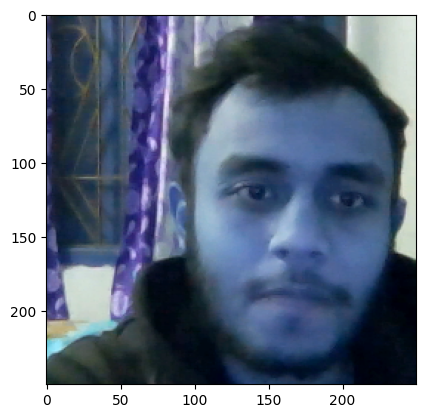

In [27]:
plt.imshow(frame[120:120+250,200:200+250,:])

# 3. Load & Pre-process Image

### 3.1 Get Image Directories

In [6]:
# it stores 300 image paths as a dataset

anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [7]:
dir_test = anchor.as_numpy_iterator()

In [8]:
dir_test.next()

b'data\\anchor\\4dbdf6e6-ba36-11ee-a3ae-c85ea939b75e.jpg'

### 3.2 Preprocess - Scale and Resize

In [9]:
# https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf

#  ↑↑↑ kept according to the above paper of siamese network ↑↑↑



def preprocess(file_path):

    # read in image from file path
    byte_img = tf.io.read_file(file_path)

    #load in the image 
    img = tf.io.decode_jpeg(byte_img)

    #pre-processing steps- resizing image by 100x100x3
    img = tf.image.resize(img, (105,105))
    img = img / 255.0
    return img

In [13]:
preprocess('data\\anchor\\4e2e7659-ba36-11ee-b2be-c85ea939b75e.jpg')

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.21446079, 0.12622549, 0.08406863],
        [0.18455882, 0.12352941, 0.08014706],
        [0.15882353, 0.12769608, 0.0747549 ],
        ...,
        [0.81789213, 0.8610294 , 0.8041667 ],
        [0.8186275 , 0.8617647 , 0.79901963],
        [0.8235294 , 0.8666667 , 0.8039216 ]],

       [[0.22647059, 0.1254902 , 0.10784314],
        [0.1860294 , 0.1252451 , 0.09877451],
        [0.17450981, 0.15588236, 0.11568628],
        ...,
        [0.8186275 , 0.8617647 , 0.8068628 ],
        [0.81789213, 0.8610294 , 0.8061274 ],
        [0.8127451 , 0.85588235, 0.8009804 ]],

       [[0.19779412, 0.1004902 , 0.09166667],
        [0.17794117, 0.1242647 , 0.11127451],
        [0.16102941, 0.14142157, 0.11936274],
        ...,
        [0.8095588 , 0.85269606, 0.7977941 ],
        [0.8117647 , 0.85269606, 0.80441177],
        [0.81078434, 0.8509804 , 0.80490196]],

       ...,

       [[0.12205882, 0.13578431, 0.07794118],
        [0.22

### 3.3 Create labelled dataset

In [46]:
# # for example

# dataset = tf.data.Dataset.from_tensor_slices(tf.ones(5))

# # Convert the dataset to a list and print it
# elements = list(dataset.as_numpy_iterator())
# print(elements)

[1.0, 1.0, 1.0, 1.0, 1.0]


In [10]:


positives = tf.data.Dataset.zip((anchor,positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [11]:
samples = data.as_numpy_iterator()

In [12]:
example = samples.next()
example

(b'data\\anchor\\43ad5136-ba36-11ee-abc3-c85ea939b75e.jpg',
 b'data\\positive\\76ca50ea-ba36-11ee-b217-c85ea939b75e.jpg',
 1.0)

### 3.4 Build Train & Test Partition

In [13]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [21]:
preprocess_twin(*example)

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[2.65686274e-01, 1.57843143e-01, 1.32843137e-01],
         [2.10539222e-01, 1.35049015e-01, 1.00245096e-01],
         [1.87009797e-01, 1.39460787e-01, 8.62745121e-02],
         ...,
         [8.46568644e-01, 8.89705896e-01, 8.34803939e-01],
         [8.45098019e-01, 8.88235271e-01, 8.33333313e-01],
         [8.43137264e-01, 8.86274517e-01, 8.31372559e-01]],
 
        [[2.66176462e-01, 1.54411763e-01, 1.45588234e-01],
         [2.28186280e-01, 1.51715681e-01, 1.34068623e-01],
         [2.09313720e-01, 1.74264699e-01, 1.40441179e-01],
         ...,
         [8.44607830e-01, 8.87745082e-01, 8.32843125e-01],
         [8.44117641e-01, 8.87254894e-01, 8.32352936e-01],
         [8.39215696e-01, 8.82352948e-01, 8.27450991e-01]],
 
        [[2.42401958e-01, 1.43627450e-01, 1.30882353e-01],
         [2.21813723e-01, 1.50490195e-01, 1.37990192e-01],
         [1.99264705e-01, 1.63480386e-01, 1.44117653e-01],
         ...,
         [8

In [14]:
# built dataloader pipeline

data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

data

<ShuffleDataset element_spec=(TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [20]:
samples = data.as_numpy_iterator()
print(len(samples.next()))
samp = samples.next()
samp

3


(array([[[0.20367648, 0.12230392, 0.08799019],
         [0.1747549 , 0.12181372, 0.07426471],
         [0.16176471, 0.13872549, 0.06519608],
         ...,
         [0.81691176, 0.8629902 , 0.80808824],
         [0.82058823, 0.8637255 , 0.8029412 ],
         [0.8235294 , 0.8666667 , 0.8039216 ]],
 
        [[0.22132353, 0.12916666, 0.09877451],
         [0.18308823, 0.12181372, 0.08063725],
         [0.19509804, 0.17230392, 0.11740196],
         ...,
         [0.8156863 , 0.8610294 , 0.8061274 ],
         [0.81789213, 0.8610294 , 0.8061274 ],
         [0.81764704, 0.85784316, 0.8039216 ]],
 
        [[0.20269608, 0.11862745, 0.09117647],
         [0.18455882, 0.12916666, 0.09877451],
         [0.16715686, 0.1487745 , 0.10539216],
         ...,
         [0.8117647 , 0.85490197, 0.8       ],
         [0.81911767, 0.85563725, 0.80735296],
         [0.8235294 , 0.85490197, 0.8098039 ]],
 
        ...,
 
        [[0.11519608, 0.13970588, 0.07205883],
         [0.20049019, 0.2122549 , 0.15563

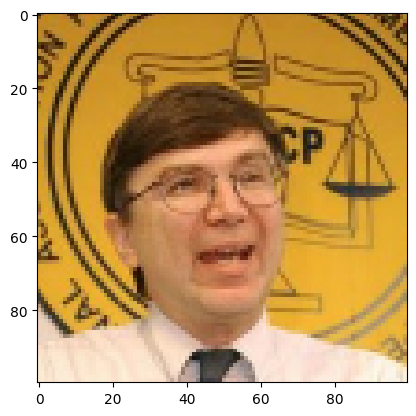

In [21]:
plt.imshow(samp[1])

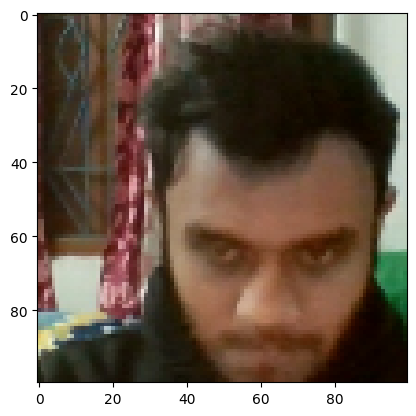

In [22]:
plt.imshow(samp[0])

In [23]:
samp[2]

0.0

#### Training partitions

In [15]:
train_data = data.take(round(len(data)*0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [16]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [17]:
train_samples = train_data.as_numpy_iterator()
train_sample = train_samples.next()
len(train_sample[0])

16

### test partition

In [18]:
test_data = data.skip(round(len(data)*0.7))
test_data = test_data.take(round(len(data)*0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [28]:
len(test_data.as_numpy_iterator().next()[0])

16

# 4. Model Engineering

### 4.1 Build Embedding Layer


[The reference for below model is directly taken from this **Siamese Neural Networks for One-shot Image Recognition** paper.](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf)


In [19]:
def make_embedding(): 
    inp = Input(shape=(105,105,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')


embedding = make_embedding()


In [39]:
embedding.summary( )

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

### 4.2 Build Distance Layer

In [20]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

    
        

### 4.3 Make Siamese Model

In [21]:
def make_siamese_model():

    #Anchor image input in the network
    input_image = Input(name='input_img', shape=(105,105,3))

    #validation image in the network 
    validation_image = Input(name='validation_img', shape=(105,105,3))


    #combine siamese distance
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image),embedding(validation_image))


    #classification layer
    classifier = Dense(1,activation='sigmoid')(distances)
    
    return Model(inputs = [input_image, validation_image], outputs=classifier, name='SiameseNetwork')





In [22]:
siamese_model = make_siamese_model()

In [38]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 5. Training

### 5.1 Setup Loss & Optimizer

In [23]:
 binary_cross_loss = tf.losses.BinaryCrossentropy()

In [24]:
opt = tf.keras.optimizers.Adam(1e-4)

In [25]:
ckeckpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(ckeckpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model = siamese_model)

### 5.2 Build Train Step Function

In [26]:
@tf.function
def train_step(batch):

    # record all of our operations
    with tf.GradientTape() as tape:

        #get anchor and positive negative image
        X = batch[:2]
        #get label
        y = batch[2]


        #forward pass
        yhat = siamese_model(X,training = True)
        # Calculate loss
        loss = binary_cross_loss(y,yhat)
    print(loss)

    #calculate gradient
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    #calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss

### 5.3 Build Training Loop

In [27]:
def train(data, EPOCHS):

    #loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch,EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        #loop through each batch
        for idx, batch in enumerate(data):
    
            #run train step here
            train_step(batch)
            progbar.update(idx+1)

        #same checkpoint
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

### 5.4 Train the model 

In [28]:
EPOCHS = 20

In [29]:
train(train_data, EPOCHS)


 Epoch 1/20
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
18/18 [==============================] - 16s 537ms/step

 Epoch 2/20
18/18 [==============================] - 10s 560ms/step

 Epoch 3/20
18/18 [==============================] - 10s 559ms/step

 Epoch 4/20
18/18 [==============================] - 10s 561ms/step

 Epoch 5/20
18/18 [==============================] - 10s 562ms/step

 Epoch 6/20
18/18 [==============================] - 10s 567ms/step

 Epoch 7/20
18/18 [==============================] - 10s 568ms/step

 Epoch 8/20
18/18 [==============================] - 10s 570ms/step

 Epoch 9/20
18/18 [==============================] - 10s 574ms/step

 Epoch 10/20
18/18 [==============================] - 10s 578ms/step

 Epoch 11/20
18/18 [==============================] - 10s 579ms/step

 Epoch 12/20
18/18 [==============================] - 10s 577ms/step

 Epoch 13/20
1

# 6. Evaluate Model

### 6.1 import metics

In [30]:


from tensorflow.keras.metrics import Precision, Recall 

In [31]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next() 

In [32]:
test_var = test_data.as_numpy_iterator().next()
len(test_var)

3

In [33]:
y_true

array([0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

### 6.2 test prediction

In [34]:
y_hat = siamese_model.predict([test_input,test_val])
y_hat

1/1 [==============================] - 0s 172ms/step


array([[2.24597920e-06],
       [9.33174988e-07],
       [1.78841368e-08],
       [7.17828408e-10],
       [8.90221372e-08],
       [1.01113571e-07],
       [9.99999285e-01],
       [9.99997854e-01],
       [1.55396293e-07],
       [3.85795573e-08],
       [4.26508535e-07],
       [1.11330101e-09],
       [6.04334957e-07],
       [1.05540465e-08],
       [9.47958778e-09],
       [9.70900071e-09]], dtype=float32)

In [35]:
[1 if prediction > 0.99 else 0 for prediction in y_hat]

[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]

In [36]:
y_true

array([0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

### 6.3 Checking metrics

In [37]:
r = Recall()


r.update_state(y_true,y_hat)
r.result().numpy()

1.0

In [38]:
p = Precision()


p.update_state(y_true,y_hat)
p.result().numpy()

1.0

### 6.4 create viz

<function matplotlib.pyplot.show(close=None, block=None)>

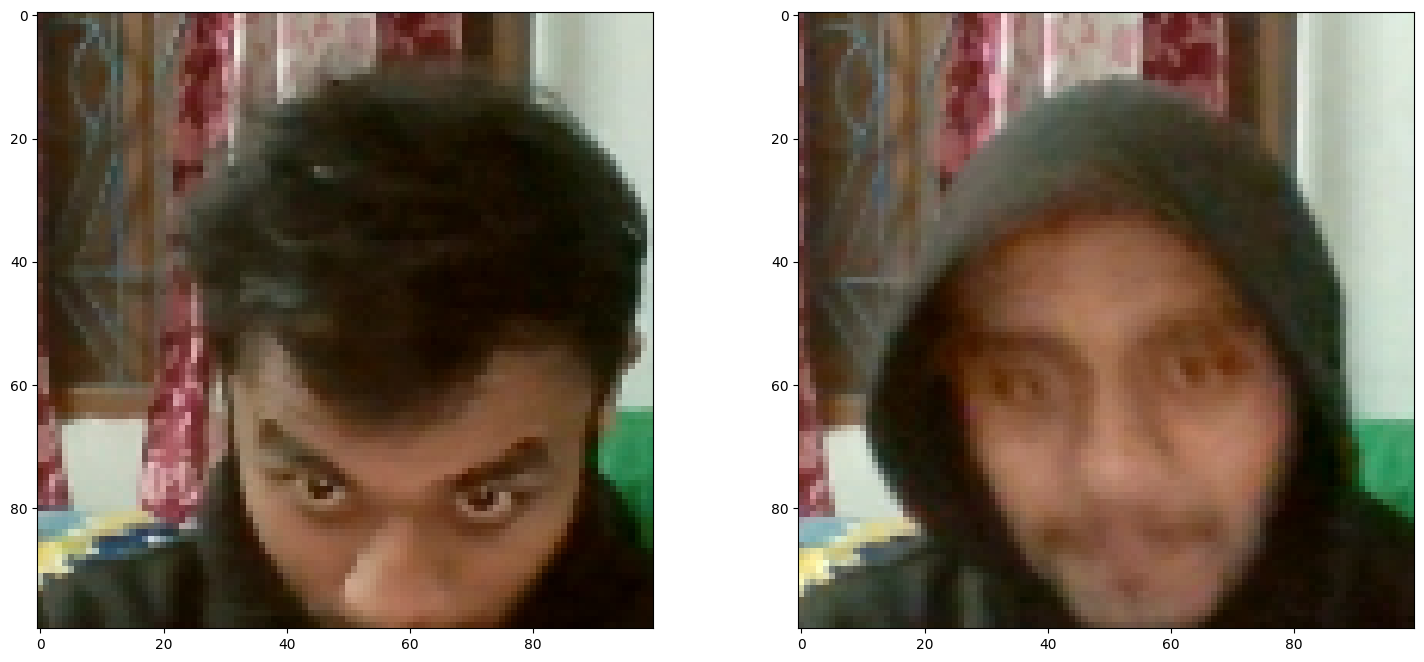

In [62]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.imshow(test_input[1])
plt.subplot(1,2,2)
plt.imshow(test_val[1])
plt.show

# 7. Save Model

In [64]:
#save weights 
siamese_model.save('siamesemodel.h5')

In [42]:
# relode model
model = tf.keras.models.load_model('siamesemodel.h5',custom_objects={'L1Dist':L1Dist,'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [43]:
model.predict([test_input,test_val])

1/1 [==============================] - 4s 4s/step


array([[9.9999988e-01],
       [3.4373351e-09],
       [5.7491734e-11],
       [2.4465487e-06],
       [9.9999309e-01],
       [9.3619656e-06],
       [4.7729049e-05],
       [4.5833644e-06],
       [2.8946645e-09],
       [9.9999690e-01],
       [9.9999988e-01],
       [2.9272067e-03],
       [9.9999928e-01],
       [7.8035029e-08],
       [1.3116853e-07],
       [1.0000000e+00]], dtype=float32)

# 8. Real Time Test

### 8.1 Verification Function

In [44]:
 # def verify(frame, model, detection_threshold, verification_threshold):
 #     # built results array
 #     results = []
 #     for image in os.listdir(os.path.join('application_data', 'verification_images')):
 #         input_img = preprocess(os.path.join('application_data','input_image','input_image.jpg'))
 #         validation_img = preprocess(os.path.join('application_data', 'verification_images',image))

 #         result = model.predict(list(np.extend_dims([input_img, validation_img],axis=1)))
 #         results.append(result)

 #    # Detection Threshold: Metric on which the prediction is considered positive
 #     detection = np.sum(np.array(results)>detection_threshold)

 #    #Verification Threshold: proportion of positive threshold / total positive threshold
 #     verification = detection / len(os.listdir(os.path.join('application_data','verification_images')))
 #     verified = verification > verification_threshold


 #     return results, verified

In [45]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

### 8.2 OpenCV Real Time Verification

In [46]:
tf.keras.utils.disable_interactive_logging()

In [50]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame = cap.read()
    frame = frame[120:120+250,200:200+250,:]
    cv2.imshow('Verification',frame)

    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        #save image to application/ input_image folder
        cv2.imwrite(os.path.join('application_data','input_image','input_image.jpg'),frame)
        results,verified = verify(model, 0.5, 0.5)
        print(verified)
        
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
    

    

False
False
True
True
True
True
True
True
